# New dataset: Boston housing

In [30]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

from src.data.utils import load_boston_dataset
from src.visualization import beautify_ax
from src.model import (
    ModelTrainer, BayesianLinearRegression, 
    QuantileRegressionMCDropoutNet, HeteroscedasticMCDropoutNet
)
from src.model.quantile_utils import create_quantiles

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sns.set_style("white")
cs = sns.color_palette(n_colors=3)

Loading the data

In [5]:
df = load_boston_dataset(return_df=True)

In [6]:
x_train, x_test, y_train, y_test = load_boston_dataset()

In [18]:
x_train

array([[1.39134e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        1.00630e+02, 1.51700e+01],
       [6.65492e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.96900e+02, 1.39900e+01],
       [3.65900e-02, 2.50000e+01, 4.86000e+00, ..., 1.90000e+01,
        3.96900e+02, 6.72000e+00],
       ...,
       [1.80846e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        2.72500e+01, 2.90500e+01],
       [7.25800e-01, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.90950e+02, 1.12800e+01],
       [7.75223e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        2.72210e+02, 1.62300e+01]])

## Little data exploration

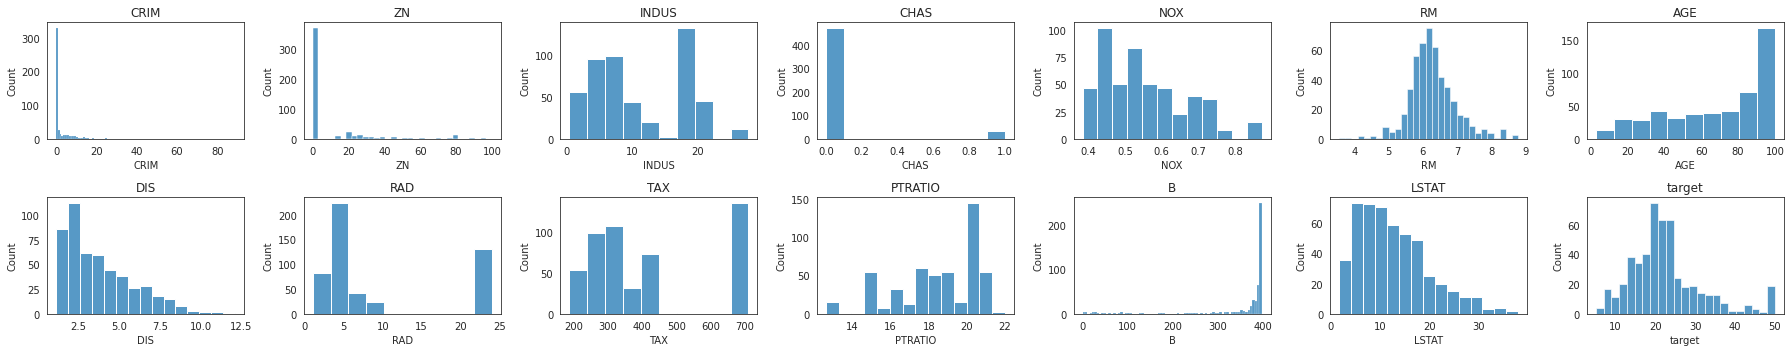

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(25,5))
for i, ax in enumerate(axes.flatten()):
    sns.histplot(df.iloc[:, i], ax=ax)
    ax.set_title(df.columns[i])
    
plt.tight_layout()

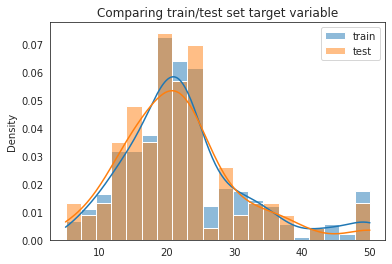

In [8]:
fig, ax = plt.subplots(1, 1)
sns.histplot(y_train.flatten(), bins=20, label='train', alpha=.5, kde=True, stat='density', color=cs[0], ax=ax)
sns.histplot(y_test.flatten(), bins=20, label='test', alpha=.5, kde=True, stat='density', color=cs[1], ax=ax)
plt.title('Comparing train/test set target variable')
plt.legend();

In [9]:
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)
QRMCDN_params = {'input_size': x_train.shape[1], 'hidden_size': 128, 'dropout_p': 0.2, 'quantiles': QUANTILES, 'dropout_dim': 1}
HMCDN_params  = {'input_size': x_train.shape[1], 'hidden_size': 256, 'dropout_p': 0.2}
BLR_params = {'input_size': x_train.shape[1]}

models = {
    "QRMCDN": QuantileRegressionMCDropoutNet(QRMCDN_params),
    "HMCDN": HeteroscedasticMCDropoutNet(HMCDN_params),
    "BLR": BayesianLinearRegression(BLR_params)
}

trainer = ModelTrainer(models, model_path='../models/')

In [10]:
fit_kwargs = {
    "QRMCDN": {'batch_size': 64, 'epochs': 501, 'print_iter': 50, 'lr': 1e-4},
    "HMCDN": {'batch_size': 64, 'epochs': 501, 'print_iter': 50, 'lr': 1e-4, 'weight_decay': 1e-6},
    "BLR": {'samples': 1000, 'tune':1000, 'init':'adapt_diag', 'nuts_kwargs': {'target_accept': 0.9}}
}

save_kwargs = {
    "BLR": {'overwrite': True}
}
trainer.train(x_train, y_train, fit_kwargs, save_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_bias, sd_scale, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:46<00:00, 130.32draws/s]


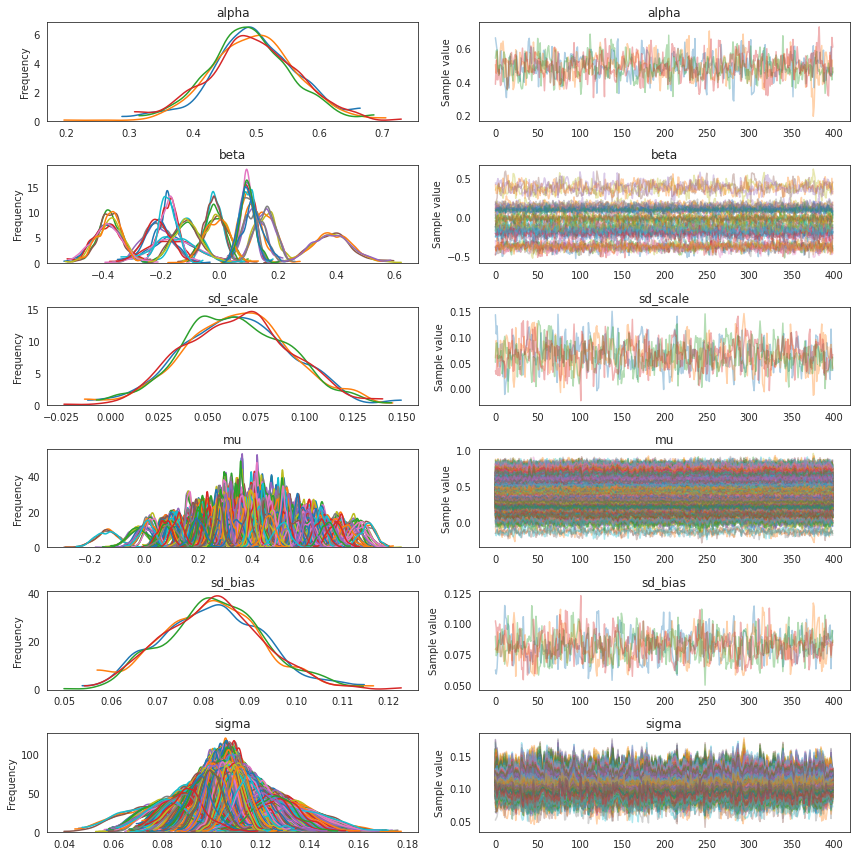

In [11]:
models['BLR'].plot_trace(skip_first_n=100)

In [12]:
predict_kwargs = {"BLR": {'quantiles': QUANTILES},
                  "HMCDN": {'quantiles': QUANTILES}}

qpreds = trainer.generate_quantile_predictions(x_test, predict_kwargs)

100%|██████████| 2000/2000 [00:45<00:00, 44.38it/s]


### Selecting some random test cases

In [13]:
random_is = np.random.randint(0, len(x_test), 9)

### Plotting the quantile predictions

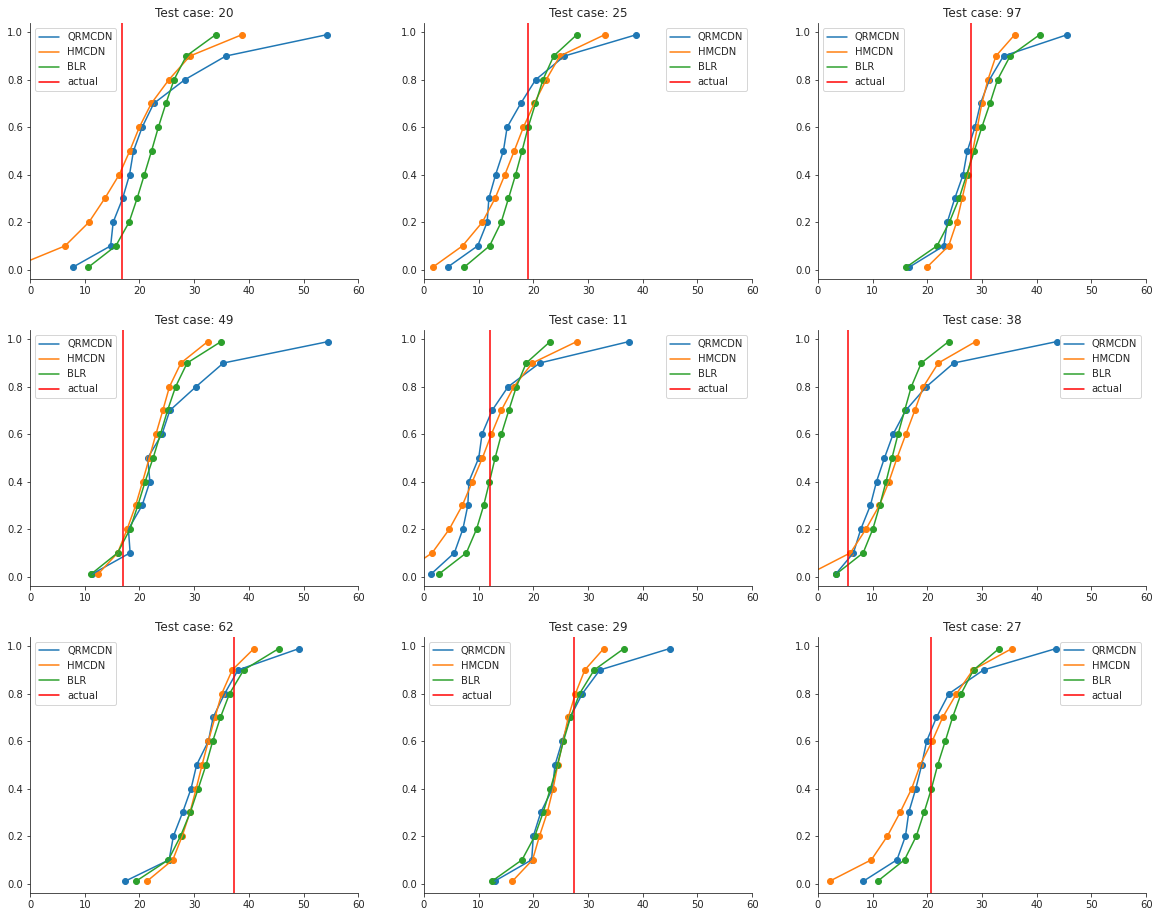

In [14]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    
    for j, (m_name, preds) in enumerate(qpreds.items()):
        ax.plot(preds[i], QUANTILES, label=m_name, color=cs[j])
        ax.scatter(preds[i], QUANTILES, color=cs[j])

    ax.axvline(y_test[i], c='r', label='actual')
    ax.set_title(f"Test case: {i}")
    ax.legend()
    ax.set_xlim(0, 60)

plt.show()

## Secondly, generating distributions

The other way around. Create an approximate posterior distribution from the output of the `QuantileRegressionMCDropoutNet`. Then we can compare it with the output from the `BayesianLinearRegression` and the `HeteroscedasticMCDropoutNet.

In [15]:
posterior_samples = trainer.generate_posterior_samples(x_test, sample_kwargs={'BLR': {'samples': 1000}})

100%|██████████| 1000/1000 [00:22<00:00, 44.30it/s]


### Plotting the approximate posterior distributions

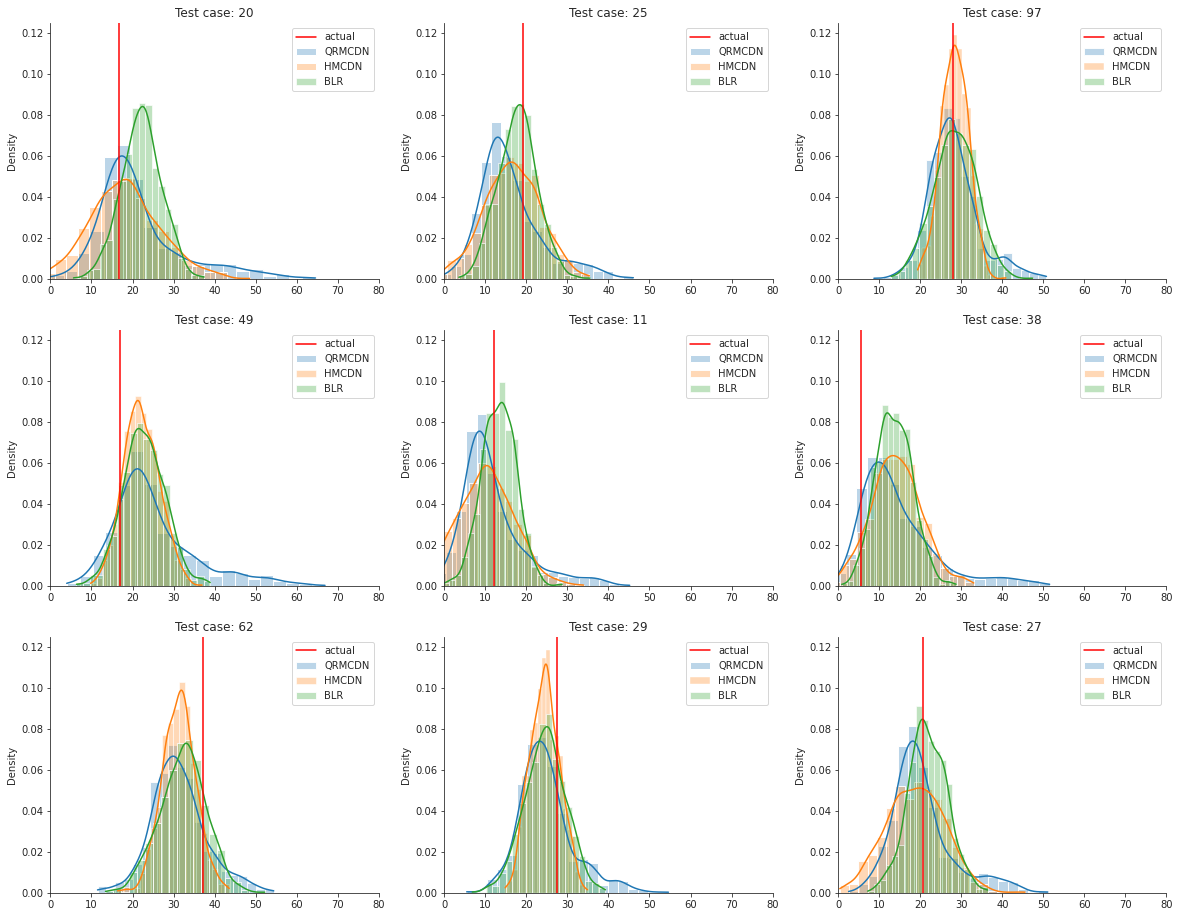

In [16]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    
    for j, (m_name, samples) in enumerate(posterior_samples.items()):
        sns.histplot(samples[i], bins=20, label=m_name, stat='density', alpha=.3, kde=True, color=cs[j], ax=ax)
    
    ax.set_title(f"Test case: {i}")
    ax.axvline(y_test[i], c='r', label='actual')
    ax.legend()
    ax.set_xlim(0, 80)
    
plt.show()

## The (continuous) ranked probability score

A metric to show how well a predicted distribution is, compared to a single value outcome. This metric calculates (or approximates) the area between the predicted distribution (represented as CDF) and the actual value (represented as Heavyside step function). The smaller this area, the better the predicted distribution fits reality.

![](https://robertsy.github.io/ensemble-da/assets/img/crps-graph.jpg)
[picture source](https://robertsy.github.io/ensemble-da/assets/img/crps-graph.jpg)

In [17]:
import properscoring as ps

for m_name, preds in qpreds.items():
    crps = ps.crps_ensemble(y_test.flatten(), preds, issorted=True).mean()
    print(f'{m_name} CRPS: {crps:.3f}')

QRMCDN CRPS: 2.551
HMCDN CRPS: 2.545
BLR CRPS: 2.542


## Calibration
Now we know how to evaluate a predicted distribution with a single true value, but how well does the distribution represent reality? Then you can compare how well this quantile fits the actual quantile. In other words, when predicting the median (quantile .5) we expect that these predictions overpredict in 50% of the cases. The same holds for the other quantiles. If you calculate this for a set of quantiles, you can make the following plot:

Text(0.5, 1.0, 'Calibration plot - Boston housing dataset')

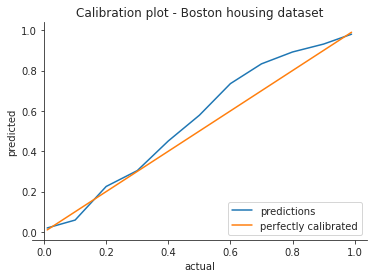

In [66]:
from src.evaluate.plots import plot_quantile_calibration

ax = plot_quantile_calibration(y_test.flatten(), preds, QUANTILES)
ax.set_title('Calibration plot - Boston housing dataset')